## Imports and constants

to do: 

transformers, features generation,
fix left bisect as described in the changed rules

In [1]:
SPLIT_SEED = 42
KFOLD_SPLITS = 5

IS_EMBEDDING_USED = True
if IS_EMBEDDING_USED:
    IS_GPU_USED = False
    FAISS_ITERATIONS = 100
    FACTORS = 100
    
IS_POLARS_USED = True
    
IS_NOTEBOOK_ON_KAGGLE = True
IS_NOTBOOK_ON_COLAB = False

IS_MODEL_TRANSFORMERS4REC = False
IS_MODEL_CATBOOST = True
IS_MODEL_RANDFOREST = False

In [2]:
!pip install feather-format >> none -q
!pip install polars -q

import bisect
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
import polars as pl
import pyarrow as pa
import pyarrow.parquet as pq
import seaborn as sns
import sklearn.metrics as m
import sys
import tensorflow as tf
import time
import warnings

from pathlib import Path
from sklearn.model_selection import KFold

if IS_EMBEDDING_USED:
    !pip install faiss-cpu --no-cache -q
    
    import implicit
    import scipy

if IS_MODEL_RANDFOREST:
    from sklearn.ensemble import RandomForestClassifier

if IS_MODEL_CATBOOST:
    from catboost import CatBoostClassifier, CatBoostRegressor, Pool

%matplotlib inline
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

In [3]:
if IS_NOTEBOOK_ON_KAGGLE:
    LOCAL_DATA_PATH = Path('/kaggle', 'input', 'mts-ml-cookies')
    DATA_FILE = Path('dataset_full.feather')
    TARGET_FILE = Path('target_train.feather')
    SUBMISSION_FILE = Path('submission.feather')

## Showing data

In [4]:
id_to_submit = pd.read_feather(Path(LOCAL_DATA_PATH, SUBMISSION_FILE))
display(id_to_submit.head(3))
display(id_to_submit.info)
id_to_submit.dropna(inplace=True)
display(id_to_submit.info)

,user_id
0,221301
1,31271
2,211594


<bound method DataFrame.info of         user_id
0        221301
1         31271
2        211594
3        253119
4        192578
...         ...
144719   415284
144720   415285
144721   415286
144722   415306
144723   415315

[144724 rows x 1 columns]>

<bound method DataFrame.info of         user_id
0        221301
1         31271
2        211594
3        253119
4        192578
...         ...
144719   415284
144720   415285
144721   415286
144722   415306
144723   415315

[144724 rows x 1 columns]>

In [5]:
targets = pd.read_feather(Path(LOCAL_DATA_PATH, TARGET_FILE)).query('age >=19') 
display(targets.head())
display(targets.info)
targets.dropna(inplace=True)
display(targets.info)

targets = pa.Table.from_pandas(targets)
display(pd.DataFrame([(z.name, z.type) for z in targets.schema], columns = [['field', 'type']]))

,age,is_male,user_id
0,31.0,1,350459
1,35.0,1,188276
2,41.0,0,99002
3,33.0,0,155506
4,54.0,0,213873


<bound method DataFrame.info of          age is_male  user_id
0       31.0       1   350459
1       35.0       1   188276
2       41.0       0    99002
3       33.0       0   155506
4       54.0       0   213873
...      ...     ...      ...
269995  49.0       1   225374
269996  22.0       1    25776
269997  28.0       0   148131
269998  28.0       1   205570
269999  68.0       1   103148

[268922 rows x 3 columns]>

<bound method DataFrame.info of          age is_male  user_id
0       31.0       1   350459
1       35.0       1   188276
2       41.0       0    99002
3       33.0       0   155506
4       54.0       0   213873
...      ...     ...      ...
269995  49.0       1   225374
269996  22.0       1    25776
269997  28.0       0   148131
269998  28.0       1   205570
269999  68.0       1   103148

[263508 rows x 3 columns]>

,field,type
0,age,double
1,is_male,string
2,user_id,int64
3,__index_level_0__,int64


In [6]:
data = pd.read_feather(Path(LOCAL_DATA_PATH, DATA_FILE))
display(data.head())

display(data.info)
data.dropna(inplace=True)
display(data.info)

,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id
0,Краснодарский край,Краснодар,Apple,iPhone 7,ad.adriver.ru,smartphone,iOS,20368.0,2022-06-15,morning,1,45098
1,Краснодарский край,Краснодар,Apple,iPhone 7,apple.com,smartphone,iOS,20368.0,2022-06-19,morning,1,45098
2,Краснодарский край,Краснодар,Apple,iPhone 7,avatars.mds.yandex.net,smartphone,iOS,20368.0,2022-06-12,day,1,45098
3,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-16,day,1,45098
4,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-30,day,1,45098


<bound method DataFrame.info of                   region_name  city_name cpe_manufacturer_name  \
0          Краснодарский край  Краснодар                 Apple   
1          Краснодарский край  Краснодар                 Apple   
2          Краснодарский край  Краснодар                 Apple   
3          Краснодарский край  Краснодар                 Apple   
4          Краснодарский край  Краснодар                 Apple   
...                       ...        ...                   ...   
322899430   Калужская область    Обнинск               Samsung   
322899431   Калужская область    Обнинск               Samsung   
322899432   Калужская область    Обнинск               Samsung   
322899433   Калужская область    Обнинск               Samsung   
322899434   Калужская область    Обнинск               Samsung   

             cpe_model_name                     url_host cpe_type_cd  \
0                  iPhone 7                ad.adriver.ru  smartphone   
1                  iPhone 7    

<bound method DataFrame.info of                   region_name  city_name cpe_manufacturer_name  \
0          Краснодарский край  Краснодар                 Apple   
1          Краснодарский край  Краснодар                 Apple   
2          Краснодарский край  Краснодар                 Apple   
3          Краснодарский край  Краснодар                 Apple   
4          Краснодарский край  Краснодар                 Apple   
...                       ...        ...                   ...   
322899430   Калужская область    Обнинск               Samsung   
322899431   Калужская область    Обнинск               Samsung   
322899432   Калужская область    Обнинск               Samsung   
322899433   Калужская область    Обнинск               Samsung   
322899434   Калужская область    Обнинск               Samsung   

             cpe_model_name                     url_host cpe_type_cd  \
0                  iPhone 7                ad.adriver.ru  smartphone   
1                  iPhone 7    

In [7]:
'''
for column in data.columns:
    sns.histplot(data[column].value_counts(), bins=4)
    plt.show()
'''

'\nfor column in data.columns:\n    sns.histplot(data[column].value_counts(), bins=4)\n    plt.show()\n'

In [8]:
for column in data.columns:
    if column not in ("date", "price", "user_id", "request_cnt"):
        data[column] = data[column].cat.codes
    elif column == "date":
        data["date"] = pd.to_datetime(data["date"])

data.head()

,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id
0,21,409,1,589,5788,2,2,20368.0,2022-06-15,2,1,45098
1,21,409,1,589,12900,2,2,20368.0,2022-06-19,2,1,45098
2,21,409,1,589,17626,2,2,20368.0,2022-06-12,0,1,45098
3,21,409,1,589,59366,2,2,20368.0,2022-05-16,0,1,45098
4,21,409,1,589,59366,2,2,20368.0,2022-05-30,0,1,45098


In [9]:
data = pl.from_pandas(data)
display(data.select(['cpe_type_cd']).to_pandas()['cpe_type_cd'].value_counts())
data['cpe_type_cd'].value_counts()

2    316272363
1        36078
3         1512
Name: cpe_type_cd, dtype: int64

cpe_type_cd,counts
i8,u32
3,1512
2,316272363
1,36078


## Counting users <-> items embedding

In [10]:
%%time
if IS_EMBEDDING_USED:
    data_agg = data.groupby(['user_id', 'url_host'], maintain_order=True).agg(
        pl.sum("request_cnt")
    )
    url_set = set(data_agg.select(['url_host']).to_pandas()['url_host'])
    print(f'{len(url_set)} urls')
    url_dict = {url: idurl for url, idurl in zip(url_set, range(len(url_set)))}
    usr_set = set(data_agg.select(['user_id']).to_pandas()['user_id'])
    print(f'{len(usr_set)} users')
    usr_dict = {usr: user_id for usr, user_id in zip(usr_set, range(len(usr_set)))}

198032 urls
404614 users
CPU times: user 1min 4s, sys: 14.3 s, total: 1min 18s
Wall time: 34.5 s


In [11]:
%%time
if IS_EMBEDDING_USED:
    values = np.array(data_agg['request_cnt'].to_pandas())
    rows = np.array(data_agg['user_id'].to_pandas().map(usr_dict))
    cols = np.array(data_agg['url_host'].to_pandas().map(url_dict))
    mat = scipy.sparse.coo_matrix((values, (rows, cols)), shape=(rows.max() + 1, cols.max() + 1))
    als = implicit.approximate_als.FaissAlternatingLeastSquares(
        factors = FACTORS, iterations = FAISS_ITERATIONS, use_gpu = IS_GPU_USED, calculate_training_loss = True, regularization = 0.1
    )

CPU times: user 1.74 s, sys: 492 ms, total: 2.24 s
Wall time: 2.22 s


In [12]:
%%time
if IS_EMBEDDING_USED:
    als.fit(mat)

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 3h 30min 56s, sys: 1h 56min 3s, total: 5h 27min
Wall time: 1h 24min 5s


In [13]:
if IS_EMBEDDING_USED:
    u_factors = als.user_factors 
    print(len(u_factors))

198032


In [14]:
if IS_EMBEDDING_USED:
    d_factors = als.item_factors
    print(len(d_factors))

404614


## Sex prediction

In [15]:
if IS_EMBEDDING_USED:
    inv_usr_map = {v: k for k, v in usr_dict.items()}
    usr_emb = pd.DataFrame(d_factors)
    usr_emb['user_id'] = usr_emb.index.map(inv_usr_map)
    usr_targets = targets.to_pandas()
    df = usr_targets.merge(usr_emb, how = 'inner', on = ['user_id'])
    df = df[df['is_male'] != 'NA']
    df = df.dropna()
    df['is_male'] = df['is_male'].map(int)
    print(df['is_male'].value_counts())

1    130899
0    125855
Name: is_male, dtype: int64


#### Model trainings

In [16]:
max_gini = 0
train_index = 0
test_index = 0

if IS_MODEL_CATBOOST:
    clf = CatBoostClassifier()
elif IS_MODEL_RANDFOREST:
    clf = RandomForestClassifier(random_state=SPLIT_SEED)

In [17]:
%%time
if IS_MODEL_CATBOOST or IS_MODEL_RANDFOREST:
    x = df.drop(['user_id', 'age', 'is_male'], axis = 1)
    y = df['is_male']

    kf = KFold(n_splits=KFOLD_SPLITS)

    for train_index, test_index in kf.split(x):
        print("Train indexes: ", train_index[:5],
              "; Test indexes: ", test_index[:5], ";\n",
              "Train length: ", len(train_index), 
              "; Test length: ", len(test_index), 
              "; Dataset length: ", len(x), ';', sep='', end='\n')
        
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        if IS_MODEL_CATBOOST:
            clf.fit(x_train, y_train, verbose = False)
        elif IS_MODEL_RANDFOREST:
            clf.fit(x_train, y_train)
        
        gini = float(f'{2 * m.roc_auc_score(y_test, clf.predict_proba(x_test)[:,1]) - 1:2.3f}')
        if gini > max_gini:
            max_gini = gini
            max_train_index = train_index
            max_test_index = test_index
        
        print(f'Current GINI is {gini}, current max is {max_gini}', end="\n\n")

Train indexes: [51351 51352 51353 51354 51355]; Test indexes: [0 1 2 3 4];
Train length: 205403; Test length: 51351; Dataset length: 256754;
Current GINI is 0.671, current max is 0.671

Train indexes: [0 1 2 3 4]; Test indexes: [51351 51352 51353 51354 51355];
Train length: 205403; Test length: 51351; Dataset length: 256754;
Current GINI is 0.667, current max is 0.671

Train indexes: [0 1 2 3 4]; Test indexes: [102702 102703 102704 102705 102706];
Train length: 205403; Test length: 51351; Dataset length: 256754;
Current GINI is 0.664, current max is 0.671

Train indexes: [0 1 2 3 4]; Test indexes: [154053 154054 154055 154056 154057];
Train length: 205403; Test length: 51351; Dataset length: 256754;
Current GINI is 0.663, current max is 0.671

Train indexes: [0 1 2 3 4]; Test indexes: [205404 205405 205406 205407 205408];
Train length: 205404; Test length: 51350; Dataset length: 256754;
Current GINI is 0.666, current max is 0.671

CPU times: user 29min 23s, sys: 29.1 s, total: 29min 52

In [18]:
print(f'Max GINI is {max_gini}')
print(f'Max train index is {max_train_index[:5]}')
print(f'Max test index is {max_test_index[:5]}')

Max GINI is 0.671
Max train index is [51351 51352 51353 51354 51355]
Max test index is [0 1 2 3 4]


In [19]:
if IS_MODEL_CATBOOST or IS_MODEL_RANDFOREST:
    if IS_MODEL_CATBOOST:
        clf.fit(x.iloc[max_train_index], y.iloc[max_train_index], verbose = False)
    elif IS_MODEL_RANDFOREST:
        clf.fit(x.iloc[max_train_index], y.iloc[max_train_index])
    id_to_submit['user_id'].unique
    id_to_submit['is_male'] = clf.predict_proba(id_to_submit.merge(usr_emb, how = 'left', on = ['user_id']).drop(['user_id'], axis = 1))[:,1]
    
id_to_submit.head()

,user_id,is_male
0,221301,0.949619
1,31271,0.500938
2,211594,0.495175
3,253119,0.510830
4,192578,0.779968


In [20]:
print("Current GINI score: ", float(f'{2 * m.roc_auc_score(y.iloc[max_test_index], clf.predict_proba(x.iloc[max_test_index])[:,1]) - 1:2.3f}'))

Current GINI score:  0.671


## Age prediction

In [21]:
def age_bucket(x):
    return bisect.bisect_left([18,25,35,45,55,65], x)

<AxesSubplot:xlabel='age', ylabel='Count'>

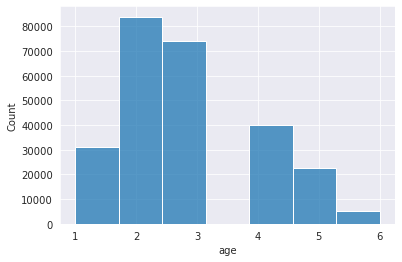

In [22]:
df = usr_targets.merge(usr_emb, how = 'inner', on = ['user_id'])
df = df[df['age'] != 'NA']
df = df.dropna()
df['age'] = df['age'].map(age_bucket)
sns.histplot(df['age'], bins = 7)

In [23]:
max_f1 = 0
train_index = 0
test_index = 0

if IS_MODEL_CATBOOST:
    clf = CatBoostClassifier()
elif IS_MODEL_RANDFOREST:
    clf = RandomForestClassifier(random_state=SPLIT_SEED)

In [24]:
if IS_MODEL_CATBOOST or IS_MODEL_RANDFOREST:
    x = df.drop(['user_id', 'age', 'is_male'], axis = 1)
    y = df['age']

    kf = KFold(n_splits=KFOLD_SPLITS)

    for train_index, test_index in kf.split(x):
        print("Train indexes: ", train_index[:5],
              "; Test indexes: ", test_index[:5], ";\n",
              "Train length: ", len(train_index), 
              "; Test length: ", len(test_index), 
              "; Dataset length: ", len(x), ';', sep='', end='\n')
        
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        if IS_MODEL_CATBOOST:
            clf.fit(x_train, y_train, verbose = False)
        elif IS_MODEL_RANDFOREST:
            clf.fit(x_train, y_train)
        
        f1 = m.f1_score(y_test, clf.predict(x_test), average='weighted')
        if f1 > max_f1:
            max_f1 = f1
            max_train_index = train_index
            max_test_index = test_index
        
        print(f'Current F1 is {f1}, current max is {max_f1}', end="\n\n")

Train indexes: [51351 51352 51353 51354 51355]; Test indexes: [0 1 2 3 4];
Train length: 205403; Test length: 51351; Dataset length: 256754;
Current F1 is 0.4140250652445793, current max is 0.4140250652445793

Train indexes: [0 1 2 3 4]; Test indexes: [51351 51352 51353 51354 51355];
Train length: 205403; Test length: 51351; Dataset length: 256754;
Current F1 is 0.4145369334090294, current max is 0.4145369334090294

Train indexes: [0 1 2 3 4]; Test indexes: [102702 102703 102704 102705 102706];
Train length: 205403; Test length: 51351; Dataset length: 256754;
Current F1 is 0.41490842578837317, current max is 0.41490842578837317

Train indexes: [0 1 2 3 4]; Test indexes: [154053 154054 154055 154056 154057];
Train length: 205403; Test length: 51351; Dataset length: 256754;
Current F1 is 0.4101823607139111, current max is 0.41490842578837317

Train indexes: [0 1 2 3 4]; Test indexes: [205404 205405 205406 205407 205408];
Train length: 205404; Test length: 51350; Dataset length: 256754;
C

In [25]:
print(f'Max F1 is {max_f1}')
print(f'Max train index is {max_train_index[:5]}')
print(f'Max test index is {max_test_index[:5]}')

Max F1 is 0.41490842578837317
Max train index is [0 1 2 3 4]
Max test index is [102702 102703 102704 102705 102706]


In [26]:
if IS_MODEL_CATBOOST or IS_MODEL_RANDFOREST:
    if IS_MODEL_CATBOOST:
        clf.fit(x.iloc[max_train_index], y.iloc[max_train_index], verbose = False)
    elif IS_MODEL_RANDFOREST:
        clf.fit(x.iloc[max_train_index], y.iloc[max_train_index])
    id_to_submit['age'] = clf.predict(id_to_submit[['user_id']].merge(usr_emb, how = 'left', on = ['user_id']).drop(['user_id'], axis = 1))
    
id_to_submit.head()

,user_id,is_male,age
0,221301,0.949619,2
1,31271,0.500938,3
2,211594,0.495175,2
3,253119,0.510830,2
4,192578,0.779968,2


In [27]:
if IS_MODEL_CATBOOST or IS_MODEL_RANDFOREST:
    print(m.classification_report(
          y.iloc[max_test_index], 
          clf.predict(x.iloc[max_test_index]), 
          target_names = ['18-25','25-34', '35-44', '45-54', '55-65', '65+']
    ))

              precision    recall  f1-score   support

       18-25       0.54      0.30      0.38      6256
       25-34       0.48      0.63      0.54     16816
       35-44       0.39      0.52      0.45     14879
       45-54       0.36      0.18      0.24      7881
       55-65       0.43      0.19      0.26      4442
         65+       0.43      0.01      0.03      1077

    accuracy                           0.44     51351
   macro avg       0.44      0.31      0.32     51351
weighted avg       0.44      0.44      0.41     51351



## Submission

In [28]:
display(id_to_submit.head())
display(id_to_submit.is_male.value_counts())
display(id_to_submit.age.value_counts())
id_to_submit.to_csv('submission.csv', index = False)

,user_id,is_male,age
0,221301,0.949619,2
1,31271,0.500938,3
2,211594,0.495175,2
3,253119,0.510830,2
4,192578,0.779968,2


0.929039    3777
0.512619     122
0.497553      94
0.487490      84
0.516534      75
            ... 
0.575533       1
0.954238       1
0.211251       1
0.623925       1
0.526347       1
Name: is_male, Length: 138232, dtype: int64

2    60220
3    58454
4    11059
1     9530
5     5352
6      109
Name: age, dtype: int64

In [29]:
print(f'Score: {max_gini + 2*max_f1}')

Score: 1.5008168515767464
